# Facial Recognition Applied To Security
Bala, Charu, Prabhat

First part project report - link

This code is available at [https://github.com/baladutt/face].

## How To Run?
Main.ipynb is the jupyter notebook to run the project. Before running that,

* LFW dataset needs to be present in data directory. For example: data/lfw/Aaron_Eckhart/
* Download http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz into models/cnn

## Referenced Links
* https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/ * https://pypi.org/project/deepface/
* https://medium.com/@williamkoehrsen/facial-recognition-using-googles-convolutional-neural-network-5aa752b4240e * https://towardsdatascience.com/capsule-networks-the-new-deep-learning-network-bd917e6818e8

## Read Image data into memory

In [1]:
import time
import getpass
import warnings
warnings.filterwarnings('ignore')

username = getpass.getuser()
start_time = time.time()
#Where is the data?
if username == "bdutt":
    baseDir="/Users/bdutt/Documents/workspace-whitespace/face/face/data/lfw-deepfunneled"
elif username =="cgarg":
    baseDir="/Users/cgarg/Documents/charu/intuit/code/face/data/lfw"
flow = "main"
debug = False

%run "Load Data.ipynb"

filenames = []
labels = []

def collectFileNamesAndLabels(filename):
    filenames.append(filename)
    result = filename.split("/") 
    labels.append(result[len(result)-2]) #Get the label name from filename
    
doForEachFile(collectFileNamesAndLabels,baseDir, 40)
print("Total File name collection time = %s seconds" % (time.time() - start_time))
print ("Files collected : ",len(filenames))

Total File name collection time = 1.0163788795471191 seconds
Files collected :  24


In [2]:
start_time = time.time()
imagesList = []
doForEachFileNames(readImage, filenames, imagesList)
print ("Images data collected : ",len(imagesList))
print("Total data collection time = %s seconds" % (time.time() - start_time))

Images data collected :  24
Total data collection time = 0.038970947265625 seconds


In [3]:
#%run "TransferLearningWithCNN.ipynb"

## Generic Multi threading code

Used later

In [4]:
import threading
import sys
import traceback
import time

class myThread (threading.Thread):
    def __init__(self, threadName, index, worker):
        threading.Thread.__init__(self)
        self.threadName = threadName
        self.index = index
        self.worker = worker
    def run(self):
        print('^',self.threadName, ', ', end='')
        try:
            self.worker(self.threadName, self.index)
        except:
            e = sys.exc_info()[0]
            print("Exception in thread: ",self.threadName,", ", e)
            traceback.print_exc()
        print('V',self.threadName, end='')
        

def runThreads(nThreads, worker):
    threads = []
    for i in range(nThreads):
        try:
            t = myThread("Thread-"+str(i), i , worker)
            threads.append(t)
            t.start()
        except:
            e = sys.exc_info()[0]
            print("Error: unable to start thread: ", e)
            traceback.print_exc()

    time.sleep(1)

    for t in threads:
        t.join()

In [5]:
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


Y = pd.DataFrame(labels, columns = ['name'])
sizeOfYLabel = len(Y)
oneDImageList = []
showOneImage = False

imageListLock = threading.Lock()

def flattenImage(image, imageList):
    # Convert RGB to single number
    global showOneImage
    if showOneImage:
        plt.imshow(image, cmap="Greys")
        plt.show()
    #gray = rgb2gray(image)
    gray = image
    if showOneImage:
        plt.imshow(gray, cmap="Greys")
        plt.show()
        showOneImage = False
    imageList.append(gray.flatten())

nThreads = 10
splitImagesList = np.array_split(imagesList, nThreads)
splitLabelsList = np.array_split(labels, nThreads)
labels = []

def imageFlatteningWorker(threadName, index):
    global splitImagesList
    global imageListLock
    imageList = []
    for image in splitImagesList[index]:
        flattenImage(image, imageList)
    imageListLock.acquire()
    global oneDImageList
    oneDImageList.extend(imageList)
    global labels
    labels.extend(splitLabelsList[index])
    imageListLock.release()

runThreads(nThreads, imageFlatteningWorker)
    
del imagesList

X = pd.DataFrame(oneDImageList)
del oneDImageList
print("X shape", X.shape)
print("label count", len(labels))
print("Total dataframe creation time = %s seconds" % (time.time() - start_time))

^^ Thread-1 , ^ Thread-0 ,  Thread-2 V Thread-1^ Thread-3 , , ^ Thread-4 , V V Thread-0V Thread-4Thread-2^ Thread-5 , V Thread-3V Thread-5^ Thread-6 , ^V Thread-6 Thread-7 , ^ Thread-8 , V^ Thread-7 Thread-9 , V Thread-8V Thread-9X shape (24, 187500)
label count 24
Total dataframe creation time = 13.531026840209961 seconds


In [6]:
Y['name'].value_counts()

Claudia_Pechstein       5
Ranil_Wickremasinghe    3
Paul_McNulty            2
John_Bond               1
Rand_Beers              1
Dragan_Covic            1
Mark_Komara             1
Bob_Newhart             1
German_Khan             1
Joanne_Woodward         1
Sureyya_Ayhan           1
Jeff_Hornacek           1
Ben_Chandler            1
Wang_Hailan             1
Deb_Santos              1
Stefano_Gabbana         1
Jimmy_Iovine            1
Name: name, dtype: int64

In [7]:
start_time = time.time()
maxFrequency = 2

# We upsample/downsample to have equal quantity of all classes

#X_sample = pd.DataFrame(columns = X.columns)
#Y_sample = pd.DataFrame(columns = Y.columns)
X_sampleList = []
Y_sampleList = []

XY_sampleLock = threading.Lock()

def equalSampleLabel(label):
    global X_sampleList
    global Y_sampleList
    global XY_sampleLock
    dfa = X[Y['name']== label]
    dfasample = dfa.sample(n=maxFrequency,replace=True)
    dfb = Y[Y['name']== label]
    dfbsample = dfb.sample(n=maxFrequency,replace=True)
    print('.', end='')
    XY_sampleLock.acquire()
    print('-', end='') 
    X_sampleList.append(dfasample)
    Y_sampleList.append(dfbsample)
    XY_sampleLock.release()
    print('+', end='')



labels = Y['name'].unique()

nThreads = 10
labelsArray = np.array_split(labels, nThreads)

def worker(threadName, index):
    for label in labelsArray[index]:
        #print(threadName, label)
        equalSampleLabel(label)

runThreads(nThreads, worker)

X_sample = pd.concat(X_sampleList)
Y_sample = pd.concat(Y_sampleList)
print(X_sample.shape)
print(Y_sample.shape)
X = X_sample
Y = Y_sample
# print(X_sample)
print("Total equal sampling time = %s seconds" % (time.time() - start_time))

^ Thread-0 , ^ Thread-1 , ^ Thread-2 , ^ Thread-3 , ^ Thread-4 , ^ Thread-5 , ^ Thread-6 , ^^ Thread-7 , ^ Thread-9 ,  Thread-8 , .-+.-+.-+.-+.-+.-+.-+V Thread-8.-+.-+V Thread-9.-+V Thread-7.-+V Thread-1.-+V Thread-3.-+V Thread-2.-+V Thread-0.-+V Thread-6.-+.-+V Thread-4V Thread-5(34, 187500)
(34, 1)
Total equal sampling time = 1.125399112701416 seconds


In [8]:
start_time = time.time()
sizeOfX = X_sample.shape[1]
#%run "DNN.ipynb"

print("Total DNN time = %s seconds" % (time.time() - start_time))

Total DNN time = 6.699562072753906e-05 seconds


In [9]:
print(X_sample.shape)


(34, 187500)


## Augment images by shifting and flipping

In [10]:
import scipy

# Take in an image as an array and return image with a [dx, dy] shift
def shift_image(image_array, shift):
    return scipy.ndimage.interpolation.shift(image_array, shift, cval=0)

# Four shifts of 30 pixels 
shifts = [[30,0], [-30,0], [0, 30], [0,-30]]

def augmentImage(image):
    shifted_images = []
    
    # Swap the color channel and height axis 
    layers = np.swapaxes(image, 0, 2)
    
    # Apply four shifts to each original image
    for shift in shifts:
        transposed_image_layers = []
        
        # Apply the shift to the image one layer at a time
        # Each layer is an RGB color channel
        for layer in layers:
            transposed_image_layers.append(shift_image(layer, shift))
            
        # Stack the RGB layers to get one image and reswap the axes
        transposed_image = np.stack(transposed_image_layers)
        transposed_image = np.swapaxes(transposed_image, 0, 2)
        
        # Add the shifted images and the labels to a list
        shifted_images.append(transposed_image)
    #print(len(shifted_images))
    shifted_images.append(np.fliplr(image)) #flip the image
    #print(len(shifted_images))
    return shifted_images

In [11]:

class_mapping = { i : labels[i] for i in range(0, len(labels) ) }
print(class_mapping)

inv_class_mapping = {v: k for k, v in class_mapping.items()}
print(inv_class_mapping)
# print(type(inv_class_mapping))
# print(inv_class_mapping['0'])

{0: 'German_Khan', 1: 'Stefano_Gabbana', 2: 'Dragan_Covic', 3: 'Jeff_Hornacek', 4: 'Sureyya_Ayhan', 5: 'Deb_Santos', 6: 'Bob_Newhart', 7: 'Wang_Hailan', 8: 'Paul_McNulty', 9: 'Jimmy_Iovine', 10: 'Claudia_Pechstein', 11: 'Ranil_Wickremasinghe', 12: 'Ben_Chandler', 13: 'Mark_Komara', 14: 'Rand_Beers', 15: 'Joanne_Woodward', 16: 'John_Bond'}
{'German_Khan': 0, 'Stefano_Gabbana': 1, 'Dragan_Covic': 2, 'Jeff_Hornacek': 3, 'Sureyya_Ayhan': 4, 'Deb_Santos': 5, 'Bob_Newhart': 6, 'Wang_Hailan': 7, 'Paul_McNulty': 8, 'Jimmy_Iovine': 9, 'Claudia_Pechstein': 10, 'Ranil_Wickremasinghe': 11, 'Ben_Chandler': 12, 'Mark_Komara': 13, 'Rand_Beers': 14, 'Joanne_Woodward': 15, 'John_Bond': 16}


## Invoke Inception Neural Network with Transfer Learning

In [12]:
from PIL import Image
import pandas as pd
import tensorflow as tf
print(X_sample.shape)
print(Y_sample.shape)
sample_dict = {}

X_transfer_learning = pd.DataFrame()
Y_transfer_learning = pd.DataFrame()


for ind in X_sample.index: 
    X_sample_array = X_sample.iloc[ind].as_matrix()
    array = X_sample_array.reshape(250,250,3)
    sample_dict[0] = array
    X_transfer_learning = X_transfer_learning.append(sample_dict,ignore_index=True)
    Y_transfer_learning = Y_transfer_learning.append(Y_sample.iloc[ind])
    
    for image in augmentImage(array):
        sample_dict[0] = image
        X_transfer_learning = X_transfer_learning.append(sample_dict,ignore_index=True)
        Y_transfer_learning = Y_transfer_learning.append(Y_sample.iloc[ind])

print(X_transfer_learning.shape)
print(Y_transfer_learning.shape)
print(type(X_transfer_learning))

(34, 187500)
(34, 1)
(204, 1)
(204, 1)
<class 'pandas.core.frame.DataFrame'>


In [13]:
label_y_sample = Y_sample.copy()
label_y_sample['name'] = label_y_sample['name'].map(inv_class_mapping)
class_images = label_y_sample['name'].value_counts()

Shape of Input to Transfer learning: X:  (204, 1) , Y:  (204, 1)
(299, 299, 3)


Using TensorFlow backend.


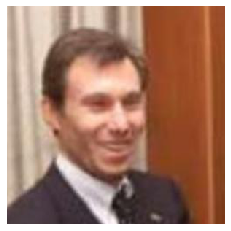

valid data shapes, X_valid:  (204, 299, 299, 3) , y_valid:  (204,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
_____________________________________________________________________________________________

Total params: 55,873,736
Trainable params: 55,813,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


Instructions for updating:
Use keras.layers.dense instead.
Done setup with n_outputs:  17
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt
Epoch:    1 Validation Loss: 14.1819 Accuracy: 0.588235
Epoch:    2 Validation Loss: 1.4625 Accuracy: 0.901961
Epoch:    3 Validation Loss: 0.6740 Accuracy: 0.906863
Epoch:    4 Validation Loss: 0.0607 Accuracy: 0.955882
Epoch:    5 Validation Loss: 0.0063 Accuracy: 0.995098
Epoch:    6 Validation Loss: 0.0001 Accuracy: 1.000000
Epoch:    7 Validation Loss: 0.0085 Accuracy: 1.000000
Epoch:    8 Validation Loss: 0.0003 Accuracy: 1.000000
Epoch:    9 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   10 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   11 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   12 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   13 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   14 Validation Loss: 0.0000 

Epoch:   57 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   58 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   59 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   60 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   61 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   62 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   63 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   64 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   65 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   66 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   67 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   68 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   69 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   70 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   71 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   72 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   73 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   74 Validation Loss: 0.0000 Accuracy: 1.000000
Epoch:   7

In [14]:
#print(Y_sample.shape)
#print(Y_sample)
warnings.filterwarnings('ignore')
start_time = time.time()
sizeOfX = X_sample.shape[1]
print("Shape of Input to Transfer learning: X: ", X_transfer_learning.shape, ", Y: ", Y_transfer_learning.shape)
%run "TransferLearning-New.ipynb"

print("Total transfer learning with CNN time = %s seconds" % (time.time() - start_time))